# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-besra'
epochs = 10
batch_size = 4
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [ ]:
def beta_score(predicted_prob_one, true_outcome, alpha_param=0.1, beta_param=3.0):
    epsilon = 1e-9
    safe_prob = np.clip(predicted_prob_one, epsilon, 1.0 - epsilon)

    if true_outcome == 1:
        # Arguments for the betaln function when the true outcome is 1
        arg1 = alpha_param
        arg2 = beta_param + 1
        arg3 = alpha_param + safe_prob
        arg4 = beta_param + 1 - safe_prob
        if not (arg1 > 0 and arg2 > 0 and arg3 > 0 and arg4 > 0):
            return -1e9
        return -betaln(arg1, arg2) + betaln(arg3, arg4)
    elif true_outcome == 0:
        # Arguments for the betaln function when the true outcome is 0
        arg1 = alpha_param + 1
        arg2 = beta_param
        arg3 = alpha_param + 1 - safe_prob
        arg4 = beta_param + safe_prob
        if not (arg1 > 0 and arg2 > 0 and arg3 > 0 and arg4 > 0):
            return -1e9
        return -betaln(arg1, arg2) + betaln(arg3, arg4)
    else:
        raise ValueError("Invalid label: true_outcome must be 0 or 1.")

def calculate_expected_beta_score(predicted_prob_one, alpha_param, beta_param):
    score_if_one = beta_score(predicted_prob_one, 1, alpha_param, beta_param)
    score_if_zero = beta_score(predicted_prob_one, 0, alpha_param, beta_param)
    
    expected_score = predicted_prob_one * score_if_one + (1.0 - predicted_prob_one) * score_if_zero
    return expected_score

def get_ensemble_predictions_for_batch(ensemble_models, input_ids, attention_mask, device):
    individual_model_probs_list = []
    with torch.no_grad():
        for model_instance in ensemble_models:
            model_instance.eval()
            model_instance.to(device)
            outputs = model_instance(input_ids.to(device), attention_mask=attention_mask.to(device))
            probs = torch.sigmoid(outputs.logits)
            individual_model_probs_list.append(probs)

        if not individual_model_probs_list:
            return torch.empty(0, device=device), []

        individual_probs_tensor = torch.stack(individual_model_probs_list)
        average_probs = torch.mean(individual_probs_tensor, dim=0)

    return average_probs, individual_model_probs_list

def besra_sampling(
    ensemble_models,
    unlabeled_data,
    train_indices,
    remaining_indices,
    estimation_data,
    tokenizer,
    num_classes,
    sampling_dur,
    new_samples,
    trials,
    alpha_param=0.1,
    beta_param=3.0,
    n_clusters=min_increment,
):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    unlabeled_dataset = NetifierDataset(unlabeled_data,
                                        np.zeros((len(unlabeled_data), num_classes)),
                                        tokenizer,
                                        max_length=sequence_length) 
    unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=batch_size, num_workers=4, pin_memory=True) 

    current_train_size = len(train_indices)

    estimation_dataset = NetifierDataset(estimation_data,
                                        np.zeros((len(estimation_data), num_classes)),
                                        tokenizer,
                                        max_length=sequence_length) # sequence_length
    estimation_dataloader = DataLoader(estimation_dataset, batch_size=len(estimation_dataset), num_workers=4, pin_memory=True)
    estimation_dataloader, unlabeled_dataloader = accelerator.prepare(estimation_dataloader, unlabeled_dataloader)

    for model in ensemble_models:
        model.to(device)
        model.eval()

    start_time = time.time()
    candidate_scores = []
    all_estimation_avg_probs = []
    all_estimation_individual_probs_by_model = []
    all_candidate_avg_probs = []
    all_candidate_individual_probs_by_model = []

    # Pre compute predictions for all estimation and candidate samples
    for est_batch in estimation_dataloader:
        est_input_ids = est_batch['input_ids']
        est_attention_mask = est_batch['attention_mask']
        est_avg_probs_batch, est_indiv_probs_batch = get_ensemble_predictions_for_batch(ensemble_models, est_input_ids, est_attention_mask, device)
        all_estimation_avg_probs.append(accelerator.gather_for_metrics(est_avg_probs_batch))

        if not all_estimation_individual_probs_by_model:
            all_estimation_individual_probs_by_model = [[] for _ in est_indiv_probs_batch]
        for model_idx, probs in enumerate(est_indiv_probs_batch):
            all_estimation_individual_probs_by_model[model_idx].append(accelerator.gather_for_metrics(probs))

    for cand_batch in unlabeled_dataloader:
        cand_input_ids = cand_batch['input_ids']
        cand_attention_mask = cand_batch['attention_mask']
        cand_avg_probs_batch, cand_indiv_probs_batch = get_ensemble_predictions_for_batch(ensemble_models, cand_input_ids, cand_attention_mask, device)
        all_candidate_avg_probs.append(accelerator.gather_for_metrics(cand_avg_probs_batch))

        if not all_candidate_individual_probs_by_model:
             all_candidate_individual_probs_by_model = [[] for _ in cand_indiv_probs_batch]
        for model_idx, probs in enumerate(cand_indiv_probs_batch):
            all_candidate_individual_probs_by_model[model_idx].append(accelerator.gather_for_metrics(probs))

    # Concatenate all batch predictions into single tensors
    all_estimation_avg_probs = torch.cat(all_estimation_avg_probs, dim=0)
    all_estimation_individual_probs = [torch.cat(model_probs, dim=0) for model_probs in all_estimation_individual_probs_by_model]
    all_candidate_avg_probs = torch.cat(all_candidate_avg_probs, dim=0)
    all_candidate_individual_probs = [torch.cat(model_probs, dim=0) for model_probs in all_candidate_individual_probs_by_model]

    accelerator.wait_for_everyone()

    # Score change calculation
    for candidate_index in range(len(all_candidate_avg_probs)):
        candidate_avg_probs_for_sample = all_candidate_avg_probs[candidate_index]
        candidate_individual_probs_for_sample = [m_probs[candidate_index] for m_probs in all_candidate_individual_probs]
        candidate_delta_q_score = 0.0

        for estimation_index in range(len(all_estimation_avg_probs)):
            estimation_avg_probs_for_sample = all_estimation_avg_probs[estimation_index]
            estimation_individual_probs_for_sample = [m_probs[estimation_index] for m_probs in all_estimation_individual_probs]

            # Calculate the initial expected score on the estimation sample before any update
            initial_expected_score_on_estimation_sample = 0.0
            for estimation_class_index in range(num_classes):
                prob_one_avg_for_est_class = estimation_avg_probs_for_sample[estimation_class_index].item()
                initial_expected_score_on_estimation_sample += calculate_expected_beta_score(prob_one_avg_for_est_class, alpha_param, beta_param)

            delta_q_for_one_estimation_sample = 0.0
            for candidate_class_index in range(num_classes):
                expected_score_after_update = 0.0
                for hypothetical_candidate_label in [0, 1]:
                    prob_one_avg_for_candidate_class = candidate_avg_probs_for_sample[candidate_class_index].item()
                    prob_of_hypothetical_label_avg = prob_one_avg_for_candidate_class if hypothetical_candidate_label == 1 else (1.0 - prob_one_avg_for_candidate_class)

                    # Bayesian Update by model reweighting
                    model_weights = []
                    for model_index in range(len(ensemble_models)):
                        prob_one_individual_for_candidate_class = candidate_individual_probs_for_sample[model_index][candidate_class_index].item()
                        prob_of_hypothetical_label_individual = prob_one_individual_for_candidate_class if hypothetical_candidate_label == 1 else (1.0 - prob_one_individual_for_candidate_class)
                        model_weights.append(prob_of_hypothetical_label_individual)

                    sum_model_weights = sum(model_weights)
                    if sum_model_weights < 1e-9:
                        normalized_model_weights = [1.0 / len(ensemble_models)] * len(ensemble_models)
                    else:
                        normalized_model_weights = [w / sum_model_weights for w in model_weights]

                    reweighted_prob_one_for_est_class = 0.0

                    # Reweight the individual model probabilities for the candidate class
                    for model_index in range(len(ensemble_models)):
                        prob_one_individual_for_est_class = estimation_individual_probs_for_sample[model_index][candidate_class_index].item()
                        reweighted_prob_one_for_est_class += normalized_model_weights[model_index] * prob_one_individual_for_est_class

                    # Calculate new scores
                    updated_expected_score_on_estimation_sample = calculate_expected_beta_score(reweighted_prob_one_for_est_class, alpha_param, beta_param)
                    expected_score_after_update += prob_of_hypothetical_label_avg * updated_expected_score_on_estimation_sample

                delta_q_for_one_estimation_sample += (expected_score_after_update - initial_expected_score_on_estimation_sample)
            candidate_delta_q_score += delta_q_for_one_estimation_sample
        candidate_scores.append(candidate_delta_q_score)
                
    # K-Means Clustering and Selection
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        candidate_scores = np.array(candidate_scores)
        candidate_scores = candidate_scores.reshape(-1, 1)
    
        accelerator.print(f"BESRA Uncertainty Score Threshold {np.percentile(candidate_scores, 90)}")
    
        target_samples = math.ceil(0.1 * len(unlabeled_data)) 
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size
    
        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
    
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(candidate_scores)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(candidate_scores[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)
    
            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    '1-FR': [y_train[i][0] for i in temp],
                    '2-GI': [y_train[i][1] for i in temp],
                    '3-PI': [y_train[i][2] for i in temp],
                    '4-DM': [y_train[i][3] for i in temp],
                    '5-EDTRB': [y_train[i][4] for i in temp],
                    '6-RE': [y_train[i][5] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])
    
            # threshold_data = pd.DataFrame({
            #     'Threshold': thresholds
            # })
            # threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [15]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        models = []
        for j in range(3):
            # model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', num_labels=6, problem_type='multi_label_classification')
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}-{percentage}')
            models.append(model)
        
        # Perform query strategy to select new samples
        estimation_pool_indices = np.random.choice(remaining_indices, size=min(8, math.ceil(0.1 * len(remaining_indices))), replace=False).tolist()
        estimation_pool_data = [X_train[i] for i in estimation_pool_indices]
        new_samples = manager.list()
        sampling_args = (
            models, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            estimation_pool_data,
            tokenizer, 
            6,
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [16]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 7, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.615, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3664, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2856, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2022, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2059, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2131, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1384, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6337, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3845, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.301, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2196, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1882, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2195, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2409, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1562, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5833, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3269, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2808, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1982, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2131, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2275, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1403,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.483, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1421, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1524, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0955, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5206, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.277, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1424, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1634, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1776, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1142, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.456, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1583, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1711, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1102, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4259, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1887, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1213, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1008, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.1005, Accuracy: 0.9567, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4454, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1955, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1334, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1314, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1073,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3984, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1751, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.176, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1033, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.1028, Accuracy: 0.9583, F1 Micro: 0.968

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.385, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.227, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2013, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1633, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1692, Accuracy: 0.9551, F1 Micro: 0.9658, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1416, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.1048, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Epoch 9/10, Train Loss: 0.0935, Accuracy: 0.9535, F1 Micro: 0.9649, F1 Macro: 0.6881
Epoch 10/10, Train Loss: 0.0652, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4016, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2339, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2051, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1659, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1825, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.152, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.1209, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.6933
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1018, Accuracy: 0.9615, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3621, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2276, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2032, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1798, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1446, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.1054, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0858, Accuracy: 0.9631, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3362, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1736, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1193, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9599, F1 Micro: 0.9696,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3587, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1827, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1705, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.1285, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0841, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6897
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3156, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1725, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1655, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1118, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7072
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7066
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9599, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3525, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1758, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1751, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0923, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9615, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3604, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1821, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1342, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6536
Epoch 8/10, Train Loss: 0.0966, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6957
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3287, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1783, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1278, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1297, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7079
Epoch 10/10, Train Loss: 0.0505, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3109, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1758, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7345
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7347
Epoch 9/10, Train Loss: 0.0513, Accuracy: 0.9535, F1 Micro: 0.9647, F1 Macro: 0.6965
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3274, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1845, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1228, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.6975
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2974, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1794, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1712, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.65
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7059
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6522
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2878, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1725, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1565, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1375, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7127
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7183
Epoch 10/10, Train Loss: 0.046, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3108, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1569, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1066, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7201
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7273
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2821, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1753, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1581, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1105, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9615, F1 Micro: 0.9703, F1 Macro: 0.6517
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7253
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Epoch 10/10, Train Loss: 0.0477, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3035, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1842, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9567, F1 Micro: 0.9673

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3162, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1864, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7258
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.7331
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2929, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.182, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.699
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.699
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7179
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.699
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2975, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2014, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9487, F1 Micro: 0.9614, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7355
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7254
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7136
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3122, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2033, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7381
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.6982
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7381
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2887, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2041, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.744
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7347
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6998
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7355
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0329, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3009, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1797, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.0798, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7189
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7355
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3057, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.183, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8112
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8041
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2897, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1787, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Epoch 6/10, Train Loss: 0.0704, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7175
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7159
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7344
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7251
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7357
Model 3 - Iteration 265:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2823, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1909, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 5/10, Train Loss: 0.1105, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7347
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7069
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7273
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.9567, F1 Micro: 0.9672, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2992, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1912, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7381
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.273, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1894, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1717, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1055, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7362
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.718
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.718
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2941, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.155, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.168, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0808, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7155
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9551, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.305, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1587, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.171, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7214
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7659
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2887, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1577, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1394, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7481
Epoch 6/10, Train Loss: 0.0769, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7337
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.7331
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7347
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.6974
Epoch 10/10, Train Loss: 0.0324, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2738, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1705, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1574, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1403, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Epoch 6/10, Train Loss: 0.0822, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7248
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7261
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7256
Epoch 10/10, Train Loss: 0.0262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2877, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1736, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9503, F1 Micro: 0.9628, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7264
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7938
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7372
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2665, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1721, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1605, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1382, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7352
Epoch 6/10, Train Loss: 0.0807, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7249
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.057, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7349
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7882
Epoch 10/10, Train Loss: 0.0258, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2854, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1691, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 6/10, Train Loss: 0.0813, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7418
Epoch 7/10, Train Loss: 0.0522, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7332
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2932, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1703, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0525, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7929
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8048
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7633
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.276, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1687, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1774, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6505
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Epoch 7/10, Train Loss: 0.0488, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7349
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7357
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.8015
Model 3 - Iteration 310:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2681, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1793, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7334
Epoch 5/10, Train Loss: 0.104, Accuracy: 0.9519, F1 Micro: 0.9639, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7372
Epoch 7/10, Train Loss: 0.0557, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.719
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7438
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7261
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2774, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1808, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9551, F1 Micro: 0.966, F1 Macro: 0.7121
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0546, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.8038
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7946
Epoch 10/10, Train Loss: 0.0333, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2587, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1802, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.176, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 5/10, Train Loss: 0.1016, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.752
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.9551, F1 Micro: 0.966, F1 Macro: 0.7406
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.8005
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.8005
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.9535, F1 Micro: 0.9647, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2616, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1712, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1511, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1212, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Epoch 5/10, Train Loss: 0.1037, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7177
Epoch 6/10, Train Loss: 0.0816, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7855
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.718
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7911
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.9551, F1 Micro: 0.966, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2751, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1739, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1538, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7507
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8057
Epoch 8/10, Train Loss: 0.0438, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8048
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9696, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2561, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1706, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.151, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1285, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1007, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.736
Epoch 7/10, Train Loss: 0.0545, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7852
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7948
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7839
Epoch 10/10, Train Loss: 0.0257, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2683, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1698, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1644, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Epoch 5/10, Train Loss: 0.1028, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7155
Epoch 6/10, Train Loss: 0.0752, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7278
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7881
Epoch 8/10, Train Loss: 0.0458, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7946
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7857
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7204
Model 1 - Iteration 34

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1741, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1501, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1069, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7457
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0754, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7954
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0584, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8066
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7214
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8213
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1712, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1041, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7271
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0721, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.803
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0541, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7683
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8215
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9615, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2521, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1132, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7381
Epoch 5/10, Train Loss: 0.0818, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.735
Epoch 6/10, Train Loss: 0.0625, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.7128
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7355
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7929
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7945
Model 1 - Iteration 35

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2589, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.162, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1317, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0901, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7358
Epoch 6/10, Train Loss: 0.0658, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7311
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7381
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7945
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2414, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1604, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1799, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1276, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7196
Epoch 5/10, Train Loss: 0.0859, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6983
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0608, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7383
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6993
Epoch 8/10, Train Loss: 0.0446, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7857
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7034
Epoch 10/10, Train Loss: 0.029, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2602, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1818, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1547, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1239, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0948, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0685, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7459
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7278
Epoch 8/10, Train Loss: 0.0401, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7694
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2806, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1792, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1335, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7678
Epoch 6/10, Train Loss: 0.0747, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7139
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7349
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7668
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2577, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1795, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1563, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1277, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7365
Epoch 5/10, Train Loss: 0.0981, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 6/10, Train Loss: 0.0661, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7258
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0541, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0365, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7025
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7956
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2483, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.181, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1518, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1339, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1007, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0736, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.779
Epoch 7/10, Train Loss: 0.0531, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0407, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8168
Epoch 9/10, Train Loss: 0.0313, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8435
Epoch 10/10, Train Loss: 0.0243, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2537, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1838, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1543, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1403, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0751, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.777
Epoch 7/10, Train Loss: 0.0523, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8167
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.8315
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2371, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1828, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 3/10, Train Loss: 0.1513, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1303, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 5/10, Train Loss: 0.0932, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Epoch 6/10, Train Loss: 0.0652, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7025
Epoch 7/10, Train Loss: 0.0471, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7939
Epoch 8/10, Train Loss: 0.0368, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7948
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7931
Epoch 10/10, Train Loss: 0.0252, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7941
Model 3 - Iteration 370: Accuracy: 0.9663, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.251, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1617, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1614, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1288, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0873, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0679, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7107
Epoch 7/10, Train Loss: 0.0571, Accuracy: 0.9551, F1 Micro: 0.9656, F1 Macro: 0.7931
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7881
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8113
Epoch 10/10, Train Loss: 0.0275, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2566, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1647, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1633, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1282, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.087, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.738
Epoch 6/10, Train Loss: 0.0668, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0535, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8048
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0381, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8133
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8206
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2432, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.162, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1247, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7382
Epoch 5/10, Train Loss: 0.0847, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.7246
Epoch 6/10, Train Loss: 0.0602, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7871
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8311
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7948
Epoch 10/10, Train Loss: 0.0264, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2544, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1554, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1363, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 4/10, Train Loss: 0.1153, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.0916, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7224
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0614, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.051, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7346
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7876
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7966
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2634, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1567, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1358, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1114, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Epoch 5/10, Train Loss: 0.0891, Accuracy: 0.9519, F1 Micro: 0.9639, F1 Macro: 0.7097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0613, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0502, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7381
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.792
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7206
Epoch 10/10, Train Loss: 0.0258, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2481, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1566, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1347, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1192, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.089, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0595, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0485, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7217
Epoch 8/10, Train Loss: 0.0432, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7842
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.9631, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2405, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1502, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1467, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1357, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0845, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0675, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7309
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0374, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7867
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7858
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2482, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1511, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1509, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0877, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7018
Epoch 6/10, Train Loss: 0.066, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7658
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8018
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0346, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7882
Epoch 9/10, Train Loss: 0.0304, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.804
Epoch 10/10, Train Loss: 0.0234, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2301, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1482, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0822, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7025
Epoch 6/10, Train Loss: 0.0574, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7357
Epoch 7/10, Train Loss: 0.0505, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7936
Epoch 8/10, Train Loss: 0.0377, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7932
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0281, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7956
Higher F1 achieved, saving model
Epoch 10/10

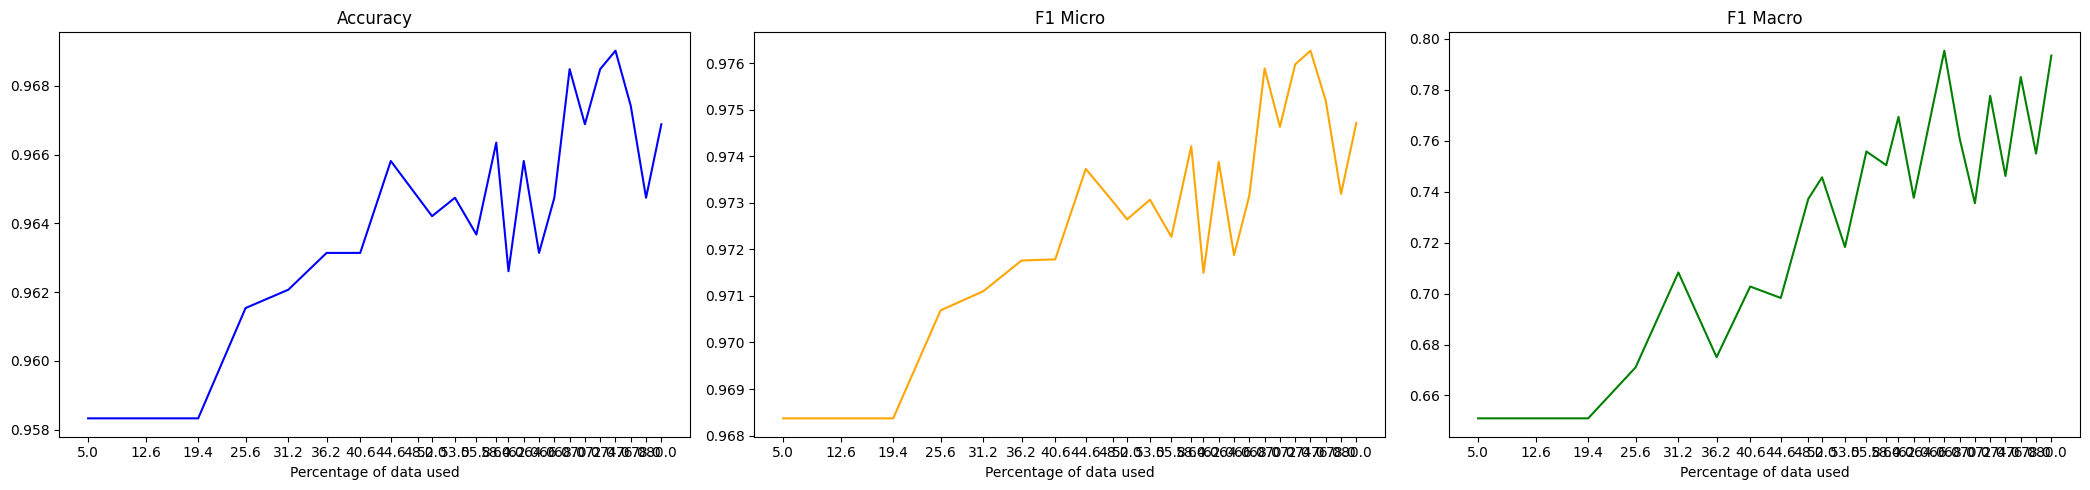

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3553, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2902, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1712, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2056, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2181, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1398,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5962, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3159, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2662, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2089, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2205, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.139, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5635, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3321, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2768, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1929, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1752, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2191, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2272, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.145, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4783, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1727, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1855, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1284, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1478, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.092, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.446, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2404, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1642, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1257, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1466, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0895, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4361, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1337, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1548, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0948, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4135, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1685, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1796, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1498, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1338, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1105, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.0886, Accuracy: 0.9567, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2409, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1657, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.148, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1342, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.1107, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 9/10, Train Loss: 0.0876, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3818, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1807, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1243, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1566, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1391, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.0931, Accuracy: 0.9519, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1952, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1982, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1844, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1334, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.1035, Accuracy: 0.9567, F1 Micro: 0.9669, F1 Macro: 0.6496
Epoch 9/10, Train Loss: 0.0959, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3297, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.191, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1916, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1804, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.1256, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 8/10, Train Loss: 0.1077, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0896, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3318, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1939, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1869, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1457, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1125, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Epoch 9/10, Train Loss: 0.0966, Accuracy: 0.9551, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3421, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1709, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1721, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1803, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1444, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7637
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9599, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3149, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1403, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.6556
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 10/10, Train Loss: 0.0543, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3205, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.17, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 7/10, Train Loss: 0.1042, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1118, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3281, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1745, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7186
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7357
Epoch 10/10, Train Loss: 0.0381, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3068, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.172, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1774, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3088, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1742, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1799, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 7/10, Train Loss: 0.1181, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.717
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3075, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2026, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7025
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7261
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7282
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2833, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1984, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1853, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7224
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7959
Epoch 9/10, Train Loss: 0.041, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7104
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2914, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.203, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1717, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1426, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1114, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7831
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3095, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1804, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7368
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7382
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6995
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8208
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2903, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1786, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1903, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7447
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.6566
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7259
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7273
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2951, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.183, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.6895
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0961, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7852
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2992, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1673, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7015
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7036
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.8143
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7558
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2802, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1644, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1647, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7201
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8057
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9679, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.285, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1621, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.1225, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6957
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7917
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7854
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2842, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2065, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1603, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.8327
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2056, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1581, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.6556
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7816
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.787
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8328
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2699, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.206, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1609, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.155, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7749
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7845
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7837
Epoch 10/10, Train Loss: 0.0398, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2872, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1779, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1777, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.746
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8051
Epoch 8/10, Train Loss: 0.0435, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8116
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.806
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0262, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2705, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1772, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1781, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7953
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8443
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.8457
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2694, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1779, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6935
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.718
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8305
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7966
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2931, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2051, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.176, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7533
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.8102
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8115
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0345, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2757, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2062, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7209
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7362
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8124
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2842, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2092, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1801, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7675
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.7995
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7872
Epoch 10/10, Train Loss: 0.037, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2832, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1876, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1846, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7283
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.786
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7684
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8099
Epoch 10/10, Train Loss: 0.0272, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2682, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1875, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1799, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7292
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8058
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8308
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9663, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2695, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1878, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.8098
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7793
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8116
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2741, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1637, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.803
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7942
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7847
Epoch 10/10, Train Loss: 0.0298, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.254, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1617, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8112
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.055, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.8051
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.04, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1625, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1846, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7865
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.8007
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.803
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7682
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2882, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.189, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7383
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7944
Epoch 7/10, Train Loss: 0.0549, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7948
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8032
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.8016
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0291, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2741, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1884, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9551, F1 Micro: 0.9653, F1 Macro: 0.7309
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7278
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.8136
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.8136
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0321, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2755, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1919, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1808, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7852
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.8298
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.8007
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.8184
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2673, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1993, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6953
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7956
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7874
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8293
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2495, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1978, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7798
Epoch 6/10, Train Loss: 0.104, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7391
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7871
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7965
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7965
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2577, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1995, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.8294
Epoch 7/10, Train Loss: 0.0617, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.8019
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.8017
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Epoch 10/10, Train Loss: 0.0298, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2817, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1969, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.175, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1369, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1093, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0738, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0478, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8124
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2626, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1932, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7007
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0722, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7234
Epoch 7/10, Train Loss: 0.0479, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7935
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7788
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.749
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2691, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1978, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7595
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0484, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0318, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2685, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.194, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1521, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0889, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0837, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7957
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0512, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8041
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.805
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8123
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2536, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1935, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1516, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6546
Epoch 5/10, Train Loss: 0.0923, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7371
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7026
Epoch 7/10, Train Loss: 0.0543, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8303
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8206
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2569, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1955, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1024, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8207
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.0573, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.0421, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7956
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8133
Epoch 10/10, Train Loss: 0.0261, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2599, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1806, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1352, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7004
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1063, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0786, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7466
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7009
Epoch 8/10, Train Loss: 0.0446, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7668
Epoch 9/10, Train Loss: 0.0292, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8033
Epoch 10/10, Train Loss: 0.0254, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2459, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1803, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 4/10, Train Loss: 0.1358, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7775
Epoch 6/10, Train Loss: 0.0804, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7897
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.8165
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8317
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2477, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.182, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1443, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7523
Epoch 6/10, Train Loss: 0.0796, Accuracy: 0.9487, F1 Micro: 0.9614, F1 Macro: 0.7697
Epoch 7/10, Train Loss: 0.0617, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6982
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.802
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.8005
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2567, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.134, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1269, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 5/10, Train Loss: 0.0961, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Epoch 6/10, Train Loss: 0.0685, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.8093
Epoch 7/10, Train Loss: 0.0496, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0413, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7635
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8198
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0234, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2445, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1576, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1303, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1362, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0984, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0735, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7283
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7502
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.765
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7932
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2475, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1609, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1372, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6956
Epoch 6/10, Train Loss: 0.0752, Accuracy: 0.9535, F1 Micro: 0.965, F1 Macro: 0.7849
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7665
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8022
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7665
Epoch 10/10, Train Loss: 0.0252, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7852
Model 3 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2417, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1787, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1495, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1159, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7448
Epoch 5/10, Train Loss: 0.1001, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.066, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8197
Epoch 7/10, Train Loss: 0.0483, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7625
Epoch 8/10, Train Loss: 0.038, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2269, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1444, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 4/10, Train Loss: 0.121, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0915, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.0652, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Epoch 7/10, Train Loss: 0.0479, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7875
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8301
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.8321
Epoch 10/10, Train Loss: 0.0189, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2335, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1782, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1528, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1291, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 5/10, Train Loss: 0.1051, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 6/10, Train Loss: 0.0649, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8198
Epoch 7/10, Train Loss: 0.0514, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7874
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7684
Epoch 10/10, Train Loss: 0.0197, Accuracy: 0.9647, F1 Micro: 0.973, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2498, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1675, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1212, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Epoch 5/10, Train Loss: 0.0886, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7264
Epoch 6/10, Train Loss: 0.0656, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.8014
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8099
Epoch 8/10, Train Loss: 0.0317, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.8089
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.8022
Epoch 10/10, Train Loss: 0.0197, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.8089
Model 1 - Iteration 3

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2347, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1665, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1545, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 4/10, Train Loss: 0.1211, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0928, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7776
Epoch 6/10, Train Loss: 0.0729, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0454, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.83
Epoch 8/10, Train Loss: 0.0348, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8038
Epoch 9/10, Train Loss: 0.0264, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8038
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0203, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2367, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1677, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1608, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0963, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7872
Epoch 6/10, Train Loss: 0.069, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7955
Epoch 7/10, Train Loss: 0.0504, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.804
Epoch 8/10, Train Loss: 0.0314, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7016
Epoch 9/10, Train Loss: 0.0262, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8039
Epoch 10/10, Train Loss: 0.0199, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2581, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1503, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1425, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6998
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.08, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.0629, Accuracy: 0.9535, F1 Micro: 0.9648, F1 Macro: 0.6877
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0364, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8317
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8325
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2445, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1488, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1392, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1382, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6546
Epoch 5/10, Train Loss: 0.0818, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7376
Epoch 6/10, Train Loss: 0.0643, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7392
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0562, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0338, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.027, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8176
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2499, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1498, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1452, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0976, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 6/10, Train Loss: 0.0681, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.8025
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6964
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0291, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.804
Epoch 10/10, Train Loss: 0.0254, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2388, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1513, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1395, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 4/10, Train Loss: 0.1225, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0885, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7025
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0614, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8113
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0441, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.79
Epoch 8/10, Train Loss: 0.0399, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7035
Epoch 9/10, Train Loss: 0.025, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7676
Epoch 10/10, Train Loss: 0.0263, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.222, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.149, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.135, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 4/10, Train Loss: 0.1252, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Epoch 5/10, Train Loss: 0.0875, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7015
Epoch 6/10, Train Loss: 0.0636, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.762
Epoch 7/10, Train Loss: 0.0434, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.8078
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0394, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0246, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8041
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0265, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2265, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1051, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7955
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0488, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8039
Epoch 8/10, Train Loss: 0.0409, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6998
Epoch 9/10, Train Loss: 0.0249, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7673
Epoch 10/10, Train Loss: 0.0257, Accuracy

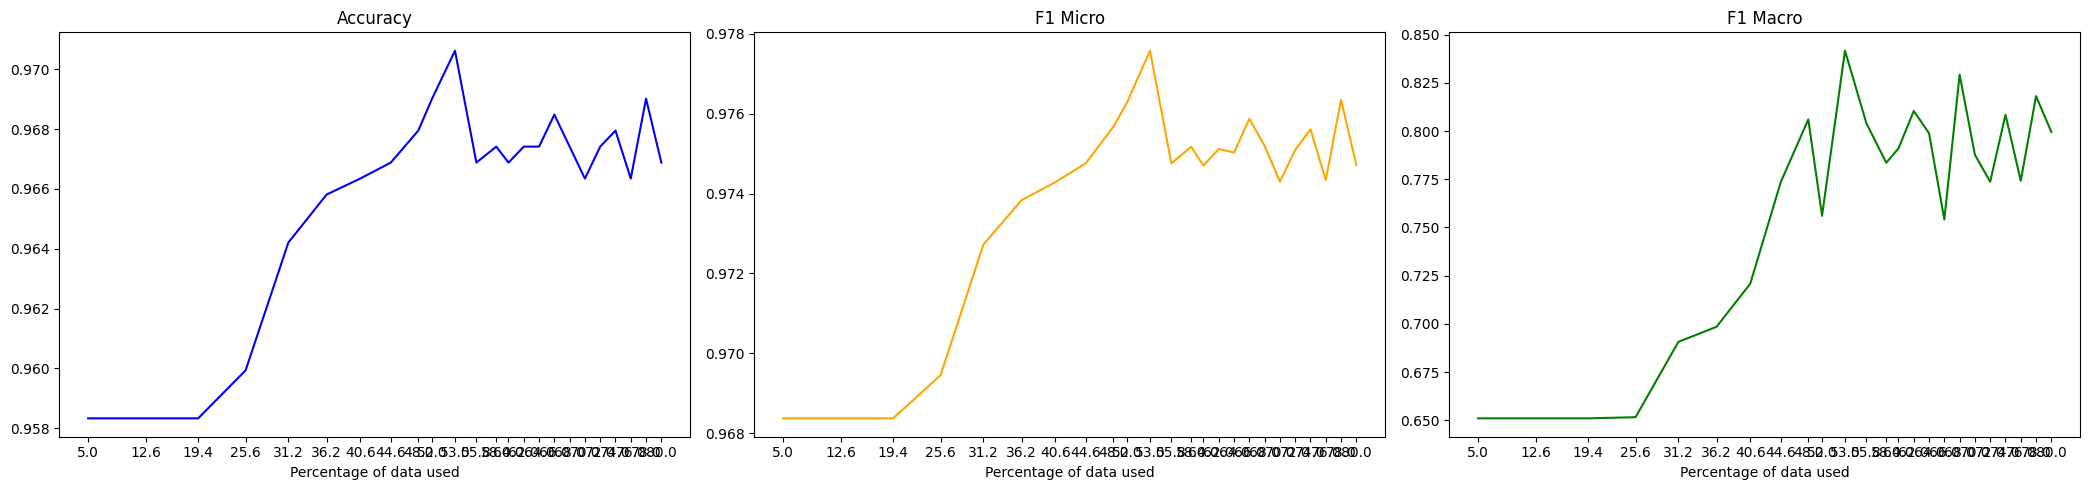

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 7, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5363, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3254, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2431, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1377, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1004, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1137,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.633, Accuracy: 0.9503, F1 Micro: 0.9616, F1 Macro: 0.645
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3689, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2519, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1279, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1128, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5157, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3148, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2375, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1435, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1565, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1387, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1233, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.101, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1101, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4361, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2218, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1902, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2031, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1897, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1429, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1578, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1387, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1255,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5077, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2347, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1904, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1541, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1395, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1217,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4203, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2235, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1874, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2015, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1937, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1635, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1468, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1382,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3926, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2251, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1803, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.182, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1377, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.1018, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0907, Accuracy: 0.9583, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4266, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2227, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1781, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1343, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.104, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 9/10, Train Loss: 0.0978, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3761, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2218, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1865, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1659, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1965, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.16, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1277, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1166, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1776, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1713, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.132, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1168, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0958, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4016, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1781, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1707, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1685, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1336, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1231, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.118, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0956, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3526, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1766, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1765, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1319, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.1223, Accuracy: 0.9583, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3398, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.198, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1527, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1413, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1615, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.108, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.1117, Accuracy: 0.9551, F1 Micro: 0.9654, F1 Macro: 0.6482
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9647, F1 Micro: 0.972

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1956, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1486, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9631, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3255, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1969, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.152, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1695, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1229, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.133, Accuracy: 0.9647, F1 Micro: 0.9726, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0731, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3111, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.167, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.109, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9599, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.337, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7637
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7259
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3024, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1671, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1536, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1314, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1125, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 9/10, Train Loss: 0.0849, Accuracy: 0.9615, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3001, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1734, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6558
Epoch 8/10, Train Loss: 0.0654, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3263, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1721, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7419
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7177
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7286
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7372
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7267
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.736
Epoch 10/10, Train Loss: 0.0469, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7124
Model 2 - Iteration 203

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2969, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1732, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1747, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1612, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 7/10, Train Loss: 0.1252, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7273
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.719
Epoch 10/10, Train Loss: 0.045, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3143, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1849, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1903, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9696, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3323, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1855, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1884, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7124
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7375
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7419
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7309
Epoch 10/10, Train Loss: 0.0363, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3067, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1882, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7223
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.9471, F1 Micro: 0.9605, F1 Macro: 0.7099
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7107
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7225
Epoch 10/10, Train Loss: 0.0372, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2788, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1899, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1525, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9679, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2947, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1907, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1478, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7177
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.728
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7939
Epoch 10/10, Train Loss: 0.0408, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2726, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1913, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1543, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.9712, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2871, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1958, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.155, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.040

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3007, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1928, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 6/10, Train Loss: 0.091, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7372
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.728
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7433
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7273
Epoch 10/10, Train Loss: 0.0417, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2785, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.196, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1153, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7206
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7438
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Epoch 10/10, Train Loss: 0.0378, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2871, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2049, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1423, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6558
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2991, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.203, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7449
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro: 0.734
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7352
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7433
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7431
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2761, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2044, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7271
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.756
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7558
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.0284, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2771, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1917, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0781, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7465
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7224
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8026
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7383
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2936, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1918, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1341, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0982, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7529
Epoch 6/10, Train Loss: 0.0706, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7428
Epoch 7/10, Train Loss: 0.0575, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0471, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8207
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.797
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2694, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1925, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1344, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7011
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0839, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7391
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7956
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7298
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2675, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1728, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9567, F1 Micro: 0.9663, F1 Macro: 0.6482
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7292
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2864, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1672, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1645, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1211, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7455
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7452
Epoch 8/10, Train Loss: 0.0558, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0388, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2609, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1707, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9551, F1 Micro: 0.9653, F1 Macro: 0.6912
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7026
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7265
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2593, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1652, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1728, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6536
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7226
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7036
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2765, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1649, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1735, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7622
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7365
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7146
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7138
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7493
Epoch 10/10, Train Loss: 0.0301, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2506, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.165, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.765
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7204
Epoch 8/10, Train Loss: 0.0457, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7156
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0261, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2771, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1812, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.162, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1551, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7025
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.0428, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.9679, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.289, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1798, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1535, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1357, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1001, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7533
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7517
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.765
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7999
Epoch 10/10, Train Loss: 0.0228, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2668, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1796, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7193
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0446, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.805
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7651
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2532, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1929, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1638, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7026
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0545, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7719
Epoch 8/10, Train Loss: 0.0448, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.0277, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7686
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2662, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1938, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.157, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1279, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7009
Epoch 5/10, Train Loss: 0.0844, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7194
Epoch 6/10, Train Loss: 0.072, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7138
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7448
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2453, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1955, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1667, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Epoch 7/10, Train Loss: 0.0575, Accuracy: 0.9567, F1 Micro: 0.9667, F1 Macro: 0.7172
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9535, F1 Micro: 0.9642, F1 Macro: 0.7916
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2578, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.8185
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7893
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7874
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0207, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2729, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1764, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1229, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0909, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Epoch 6/10, Train Loss: 0.0803, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7518
Epoch 7/10, Train Loss: 0.0572, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8208
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.8098
Epoch 10/10, Train Loss: 0.0253, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2555, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1771, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0552, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0402, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8098
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7451
Epoch 10/10, Train Loss: 0.0196, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2574, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1801, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.161, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.135, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1031, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7218
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6557
Epoch 7/10, Train Loss: 0.0494, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0429, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7711
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1819, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1061, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0819, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7448
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0443, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.8039
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7355
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7855
Epoch 10/10, Train Loss: 0.0273, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2509, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1821, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1604, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1328, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 5/10, Train Loss: 0.0974, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7312
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.8203
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8179
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8633
Epoch 10/10, Train Loss: 0.0268, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2624, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1539, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1537, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0804, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.79
Epoch 7/10, Train Loss: 0.0511, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7701
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7018
Epoch 9/10, Train Loss: 0.0281, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7004
Epoch 10/10, Train Loss: 0.0249, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2752, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1513, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 3/10, Train Loss: 0.1364, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1189, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7629
Epoch 5/10, Train Loss: 0.1072, Accuracy: 0.9487, F1 Micro: 0.9616, F1 Macro: 0.7106
Epoch 6/10, Train Loss: 0.0801, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0542, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7469
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7452
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9647, F1 Micro: 0.9732, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2543, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1551, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9487, F1 Micro: 0.9616, F1 Macro: 0.7135
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0547, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.74
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2374, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1588, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 5/10, Train Loss: 0.097, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.068, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0509, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0377, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 9/10, Train Loss: 0.0263, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7092
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2503, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1574, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1525, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1235, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Epoch 5/10, Train Loss: 0.0975, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0689, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8039
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2295, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1597, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1075, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7282
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0739, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7222
Epoch 7/10, Train Loss: 0.0525, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7933
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0372, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7035
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7799
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2405, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1722, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1501, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1198, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Epoch 5/10, Train Loss: 0.0959, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6994
Epoch 6/10, Train Loss: 0.0665, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.6992
Epoch 7/10, Train Loss: 0.0494, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7456
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8318
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2541, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1722, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1456, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1007, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Epoch 5/10, Train Loss: 0.0828, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0655, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 7/10, Train Loss: 0.0527, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0369, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7929
Epoch 10/10, Train Loss: 0.0229, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2364, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.171, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1549, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.129, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1047, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Epoch 6/10, Train Loss: 0.0773, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7362
Epoch 7/10, Train Loss: 0.0608, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0257, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8049
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.241, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1777, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1214, Accuracy: 0.9519, F1 Micro: 0.9638, F1 Macro: 0.6844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.087, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7355
Epoch 6/10, Train Loss: 0.0629, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0436, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0342, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7034
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0269, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7882
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2512, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1791, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1567, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0928, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0832, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7642
Epoch 6/10, Train Loss: 0.0637, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7448
Epoch 7/10, Train Loss: 0.0472, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.8291
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0371, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8318
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.8172
Epoch 10/10, Train Loss: 0.0247, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2344, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1787, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1278, Accuracy: 0.9535, F1 Micro: 0.965, F1 Macro: 0.7278
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0948, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Epoch 6/10, Train Loss: 0.0723, Accuracy: 0.9535, F1 Micro: 0.9651, F1 Macro: 0.728
Epoch 7/10, Train Loss: 0.0515, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.035, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7392
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.8026
Epoch 10/10, Train Loss: 0.0217, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2323, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1593, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1491, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0706, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8123
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0431, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8048
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7447
Epoch 9/10, Train Loss: 0.0245, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7683
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2458, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1603, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 3/10, Train Loss: 0.1355, Accuracy: 0.9519, F1 Micro: 0.9639, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1143, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.728
Epoch 5/10, Train Loss: 0.0846, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.727
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.744
Epoch 7/10, Train Loss: 0.0487, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7198
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7372
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7864
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7862
Model 2 - Iteration 390: Accuracy: 0.9631, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2268, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1591, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1493, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1002, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0488, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8167
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7362
Epoch 9/10, Train Loss: 0.025, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7882
Epoch 10/10, Train Loss: 0.0226, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2301, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1733, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1407, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1194, Accuracy: 0.9551, F1 Micro: 0.9652, F1 Macro: 0.6476
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0818, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7008
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0497, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.8038
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0431, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7881
Epoch 8/10, Train Loss: 0.0288, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Epoch 9/10, Train Loss: 0.0261, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7955
Epoch 10/10, Train Loss: 0.0241, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2416, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1245, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0944, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0696, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7444
Epoch 6/10, Train Loss: 0.048, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7267
Epoch 7/10, Train Loss: 0.0457, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.8009
Epoch 8/10, Train Loss: 0.0288, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.743
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.8014
Epoch 10/10, Train Loss: 0.0224, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2255, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1729, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1431, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1196, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0804, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7328
Epoch 6/10, Train Loss: 0.055, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7435
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0448, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.805
Epoch 8/10, Train Loss: 0.0305, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7196
Epoch 9/10, Train Loss: 0.0255, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8013
Higher F1 achieved, saving model
Epoch 10/

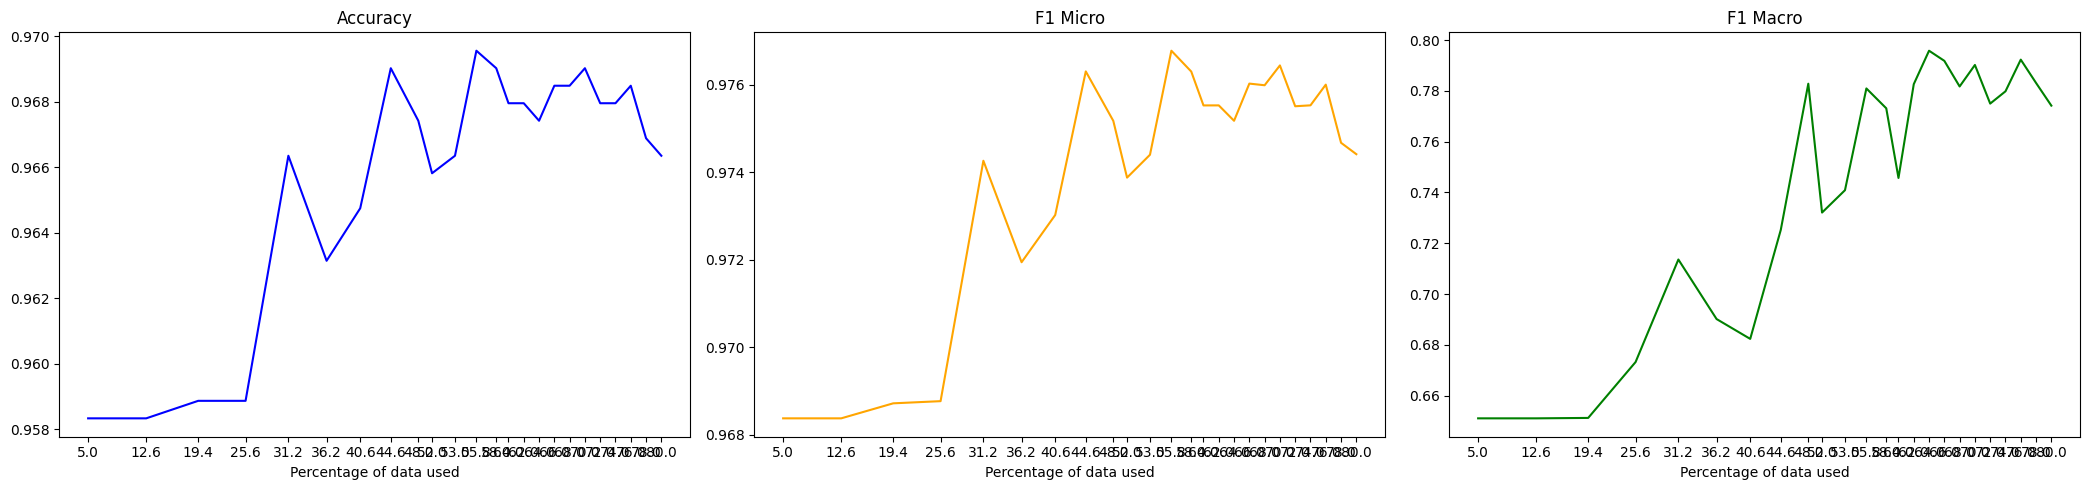

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5316, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2956, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2582, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1852, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2125, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2292, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1491,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6001, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.321, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2749, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.16, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2152, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2232, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.141, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5396, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2802, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2431, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1939, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2098, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1334, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4083, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2581, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1375, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1585, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.172, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1281, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4619, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.188, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1531, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.1165, Accuracy: 0.9567, F1 Micro: 0.9671

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4097, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1597, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1296, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1487, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1602, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1175,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3493, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1795, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1238, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1348, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.1123, Accuracy: 0.9519, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3871, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1797, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1808, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1385, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.1201, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6497
Epoch 9/10, Train Loss: 0.1023, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3446, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1763, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1136, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1178, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.1, Accuracy: 0.9583, F1 Micro: 0.9681,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.313, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2038, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1535, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1972, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1813, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1827, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1669, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1193, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.6509
Epoch 9/10, Train Loss: 0.1081, Accuracy: 0.9583, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3338, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2075, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.155, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1988, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1779, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1717, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.164, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1206, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Epoch 9/10, Train Loss: 0.1041, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6501
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3018, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2062, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1506, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1933, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1699, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1559, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1383, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6497
Epoch 9/10, Train Loss: 0.0825, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6497
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2964, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.189, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1526, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.137, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Epoch 8/10, Train Loss: 0.1321, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7167
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3164, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1905, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.167, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1323, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9535, F1 Micro: 0.9644, F1 Macro: 0.6477
Epoch 8/10, Train Loss: 0.1122, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6497
Epoch 10/10, Train Loss: 0.0522, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2891, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1897, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Epoch 8/10, Train Loss: 0.1059, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9599, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2888, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1885, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1511, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 7/10, Train Loss: 0.1299, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.6509
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6504
Epoch 10/10, Train Loss: 0.0496, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3116, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1899, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1651, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.1479, Accuracy: 0.9551, F1 Micro: 0.9657, F1 Macro: 0.6487
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9551, F1 Micro: 0.9657, F1 Macro: 0.6487
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6505
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 10/10, Train Loss: 0.0485, Accuracy: 0.9551, F1 Micro: 0.9656, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2793, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1893, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1662, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1478, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0817, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 10/10, Train Loss: 0.0463, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2829, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1928, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1899, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1685, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0685, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7183
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7182
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2974, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1964, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1768, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1854, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 6/10, Train Loss: 0.1647, Accuracy: 0.9567, F1 Micro: 0.9669, F1 Macro: 0.6496
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 10/10, Train Loss: 0.0412, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1955, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1926, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1605, Accuracy: 0.9663, F1 Micro: 0.9739, F1 Macro: 0.6544
Epoch 6/10, Train Loss: 0.141, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6497
Epoch 7/10, Train Loss: 0.0921, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6983
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2889, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.183, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1565, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1328, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.7246
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9647, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.305, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1852, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9551, F1 Micro: 0.9658, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Epoch 10/10, Train Loss: 0.0509, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2852, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1837, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1743, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.161, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.134, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2613, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7463
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7959
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7952
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7953
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7942
Epoch 10/10, Train Loss: 0.0324, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1724, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1666, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9583, F1 Micro: 0.9678, F1 Macro: 0.6499
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9535, F1 Micro: 0.9648, F1 Macro: 0.7112
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9535, F1 Micro: 0.9646, F1 Macro: 0.6912
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 10/10, Train Loss: 0.039, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2568, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1781, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1676, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7947
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7014
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7433
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7166
Epoch 10/10, Train Loss: 0.0368, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2543, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2064, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7066
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7342
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6993
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2691, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2078, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1857, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1335, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.1054, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6982
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.6895
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2552, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2066, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6948
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7015
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0337, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2574, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1827, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1527, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7271
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.777
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2686, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.16, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9551, F1 Micro: 0.9657, F1 Macro: 0.7144
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9551, F1 Micro: 0.966, F1 Macro: 0.6925
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.693
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2526, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.161, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.181, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7442
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7009
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7623
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7368
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7444
Model 3 - Iteration 265

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2762, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1889, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1653, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.797
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7772
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2896, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1874, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1672, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.728
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6991
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9551, F1 Micro: 0.966, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0355, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2786, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1877, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.165, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7659
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7969
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7782
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7568
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2667, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1729, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1744, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.9503, F1 Micro: 0.9628, F1 Macro: 0.7177
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9519, F1 Micro: 0.9638, F1 Macro: 0.7148
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7649
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0328, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.277, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1707, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7374
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7644
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 10/10, Train Loss: 0.0277, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2664, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1739, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1694, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7368
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7197
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7342
Epoch 8/10, Train Loss: 0.0524, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7264
Epoch 10/10, Train Loss: 0.0242, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2436, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1804, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7946
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7789
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.9663, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2551, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.182, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1511, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 6/10, Train Loss: 0.0843, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7009
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7005
Epoch 8/10, Train Loss: 0.0409, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8197
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0313, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2391, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1824, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1494, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7381
Epoch 6/10, Train Loss: 0.0779, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0614, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Epoch 8/10, Train Loss: 0.0369, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7442
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0236, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2578, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1723, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0685, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7344
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7632
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.763
Model 1 - Iteration 310: Accuracy: 0.9663, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2692, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1696, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7189
Epoch 6/10, Train Loss: 0.0791, Accuracy: 0.9551, F1 Micro: 0.966, F1 Macro: 0.7283
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6998
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7376
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.26, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1709, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1755, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.139, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0813, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7384
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7391
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.805
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2296, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1723, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7011
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7189
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7352
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2422, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1793, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6935
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7382
Epoch 7/10, Train Loss: 0.0541, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7849
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7183
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.712
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2275, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1734, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.176, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7358
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7433
Epoch 7/10, Train Loss: 0.0507, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7273
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.819
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7441
Epoch 10/10, Train Loss: 0.0335, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7349
Model 3 - Iteration 320:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2404, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1826, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1695, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1292, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1037, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 6/10, Train Loss: 0.0766, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7956
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1849, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1261, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 5/10, Train Loss: 0.1029, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7016
Epoch 6/10, Train Loss: 0.0676, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7018
Epoch 7/10, Train Loss: 0.0545, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7274
Epoch 8/10, Train Loss: 0.0435, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7268
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7264
Epoch 10/10, Train Loss: 0.0219, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7274
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2396, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1837, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1664, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1193, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 5/10, Train Loss: 0.0936, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Epoch 6/10, Train Loss: 0.0658, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Epoch 7/10, Train Loss: 0.0502, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7267
Epoch 8/10, Train Loss: 0.0384, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7263
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7995
Epoch 10/10, Train Loss: 0.0252, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7281
Model 3 - Iteration 33

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2264, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1653, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7419
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7659
Epoch 8/10, Train Loss: 0.042, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Epoch 9/10, Train Loss: 0.0265, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7358
Epoch 10/10, Train Loss: 0.0232, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2392, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1679, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1644, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1438, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7018
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0537, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7939
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0269, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2263, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1671, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1601, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 5/10, Train Loss: 0.1093, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7449
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.04, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 9/10, Train Loss: 0.0249, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.795
Epoch 10/10, Train Loss: 0.0259, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2419, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.17, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1777, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.131, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1054, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.074, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.766
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.8644
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7649
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1689, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1779, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1248, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.0915, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Epoch 6/10, Train Loss: 0.0669, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.699
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.8762
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2373, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1681, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1743, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1151, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 5/10, Train Loss: 0.081, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7266
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0682, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.739
Epoch 7/10, Train Loss: 0.0525, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7271
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7881
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7872
Epoch 10/10, Train Loss: 0.027, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2333, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1581, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0812, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7365
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.8009
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7635
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7347
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2407, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1713, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.159, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7005
Epoch 6/10, Train Loss: 0.0713, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7292
Epoch 8/10, Train Loss: 0.0359, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7872
Epoch 10/10, Train Loss: 0.0185, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2288, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1725, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.155, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1303, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1009, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7649
Epoch 6/10, Train Loss: 0.0602, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7673
Epoch 7/10, Train Loss: 0.0485, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7449
Epoch 8/10, Train Loss: 0.0307, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.8162
Epoch 10/10, Train Loss: 0.0155, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2139, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1765, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1565, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.129, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0945, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7182
Epoch 6/10, Train Loss: 0.0675, Accuracy: 0.9551, F1 Micro: 0.9663, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.8298
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8307
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0267, Accuracy: 0.9679, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2238, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1766, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.153, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1193, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.0916, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7183
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8303
Epoch 8/10, Train Loss: 0.0448, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7855
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8022
Epoch 10/10, Train Loss: 0.0243, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2129, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1747, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1499, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1142, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0868, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Epoch 6/10, Train Loss: 0.0556, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7844
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0516, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 8/10, Train Loss: 0.0352, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7852
Epoch 9/10, Train Loss: 0.0261, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7249
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2235, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1469, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7639
Epoch 6/10, Train Loss: 0.0723, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.744
Epoch 7/10, Train Loss: 0.0554, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7349
Epoch 8/10, Train Loss: 0.0434, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7618
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0261, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2363, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1474, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.159, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6953
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0533, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8317
Epoch 9/10, Train Loss: 0.0319, Accuracy: 0.9679, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.225, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1482, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1559, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1344, Accuracy: 0.9535, F1 Micro: 0.965, F1 Macro: 0.7116
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1018, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7297
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0644, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7789
Epoch 7/10, Train Loss: 0.0493, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8018
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.8007
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.8023
Epoch 10/10, Train Loss: 0.0231, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2182, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1594, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1509, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.132, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0953, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0749, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7942
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0488, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0348, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.02

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2264, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1594, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1495, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1214, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0872, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7267
Epoch 6/10, Train Loss: 0.0685, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7842
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0432, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7365
Epoch 9/10, Train Loss: 0.0252, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7864
Epoch 10/10, Train Loss: 0.0211, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2174, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1585, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1445, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1148, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Epoch 5/10, Train Loss: 0.0836, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7309
Epoch 6/10, Train Loss: 0.0663, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.785
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0416, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0301, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7468
Epoch 9/10, Train Loss: 0.024, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7282
Epoch 10/10, Train Loss: 0.0183, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2195, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1722, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1535, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1286, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0796, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7381
Epoch 6/10, Train Loss: 0.0687, Accuracy: 0.9631, F1 Micro: 0.9714, F1 Macro: 0.7181
Epoch 7/10, Train Loss: 0.0467, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.8096
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0315, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.803
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.778
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2261, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1707, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1463, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1206, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Epoch 5/10, Train Loss: 0.0728, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6983
Epoch 6/10, Train Loss: 0.0626, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7248
Epoch 7/10, Train Loss: 0.0414, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7915
Epoch 8/10, Train Loss: 0.0364, Accuracy: 0.9535, F1 Micro: 0.9648, F1 Macro: 0.7648
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.784
Epoch 10/10, Train Loss: 0.0228, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7928
Model 2 - Iteration 4

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2183, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1733, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1448, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1072, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0692, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0588, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8067
Epoch 7/10, Train Loss: 0.0425, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0301, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8151
Epoch 9/10, Train Loss: 0.0253, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.8135
Epoch 10/

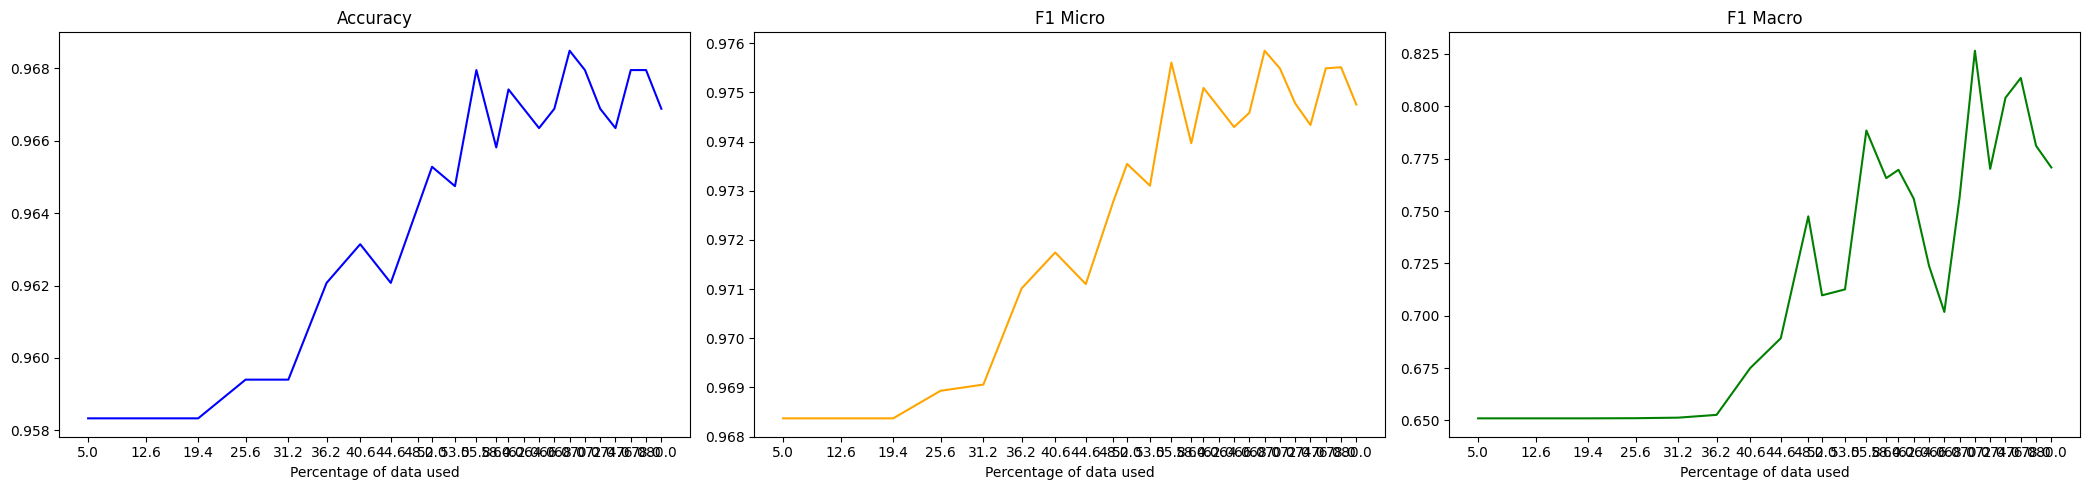

In [20]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5613, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3141, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2349, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.212, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2173, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1608, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1909, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.158, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5537, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3132, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2322, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.213, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.218, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.163, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1988, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1598, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1621, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5777, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3226, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2502, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2242, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.23, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1735, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2076, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.17, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1708, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4548, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2428, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2038, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1979, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.193, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1605, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1401, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1235, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.1334, Accuracy: 0.9567, F1 Micro: 0.967

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4391, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2386, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2037, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2005, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1986, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1692, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1385, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1141, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1399,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.456, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2212, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2086, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2049, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1747, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1558, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1393, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1669, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.379, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.23, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1523, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2135, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.192, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1367, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.1407, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 8/10, Train Loss: 0.1179, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6509
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3617, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2286, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1494, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2051, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1835, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1292, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0788

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2371, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2152, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1985, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1513, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1555, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1432, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1015

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3271, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.213, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1288, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1229, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.0942, Accuracy: 0.9519, F1 Micro: 0.963

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3271, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2133, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1141, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1048, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0741, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3389, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2256, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1402, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1335, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1364, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1101,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3088, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1652, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1554, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1349, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0967, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9599, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3002, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1632, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0571

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3148, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1712, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1644, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1266, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1363, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2913, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1657, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1538, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.1258, Accuracy: 0.9551, F1 Micro: 0.9653, F1 Macro: 0.648
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0965, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Epoch 9/10, Train Loss: 0.0656, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7001
Epoch 10/10, Train Loss: 0.0509, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.283, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1631, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.149, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.126, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9599, F1 Micro: 0.969

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2984, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1683, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1718, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1694, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1576, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 8/10, Train Loss: 0.11, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.9663, F1 Micro: 0.974

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2816, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1854, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1846, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1438, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1095, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7185
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2735, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1851, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1408, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.052

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2894, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.19, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1861, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1571, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1474, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.1091, Accuracy: 0.9519, F1 Micro: 0.9638, F1 Macro: 0.6844
Epoch 8/10, Train Loss: 0.0718, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7082
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.282, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1931, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.157, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7069
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7104
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7479
Epoch 10/10, Train Loss: 0.0472, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2766, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1938, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.154, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1245, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.695
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6998
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7018
Epoch 10/10, Train Loss: 0.0405, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2895, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1968, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1579, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1622, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1662, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 6/10, Train Loss: 0.1525, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1163, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6905
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2707, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1815, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1852, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7066
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7217
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7548
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7509
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7486
Epoch 10/10, Train Loss: 0.049, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2695, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1834, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 6/10, Train Loss: 0.1069, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7291
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6946
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1864, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1883, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7026
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7374
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7327
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7083
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1858, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1815, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1336, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7449
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7535
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.273, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1835, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7198
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7426
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7271
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2833, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.186, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6912
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7257
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 10/10, Train Loss: 0.0482, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1874, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1708, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1412, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7457
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7437
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7775
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2675, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1876, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7281
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7267
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7477
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7342
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2811, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1905, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.7246
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.708
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2818, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1768, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1644, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7008
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7538
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.752
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7362
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2776, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1793, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1625, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7025
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7418
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2887, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1821, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.751
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7263
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7512
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.743
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2685, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1891, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7393
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7307
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7659
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Epoch 10/10, Train Loss: 0.0237, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2657, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1905, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.72
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7264
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7288
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0421, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7434
Epoch 10/10, Train Loss: 0.0232, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2745, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.193, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.779
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9599, F1 Micro: 0.969, F1 Macro: 0.7597
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7193
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7258
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2546, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1788, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7452
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9583, F1 Micro: 0.9679, F1 Macro: 0.7246
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7307
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7958
Epoch 9/10, Train Loss: 0.0437, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7751
Epoch 10/10, Train Loss: 0.0306, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2503, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1759, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.162, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7218
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7374
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.8319
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7666
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2617, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1805, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1617, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7994
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9663, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2488, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1828, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7226
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7225
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7283
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7966
Epoch 9/10, Train Loss: 0.0269, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Epoch 10/10, Train Loss: 0.0253, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2463, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1816, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7016
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7973
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.257, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1856, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1077, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7218
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6943
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7771
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2422, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1663, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7538
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7283
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.8038
Epoch 10/10, Train Loss: 0.0225, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.241, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1665, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1684, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7556
Epoch 7/10, Train Loss: 0.0594, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7955
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8067
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7965
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2486, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1679, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1687, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1442, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0584, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7709
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9679, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2584, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1831, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1867, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Epoch 6/10, Train Loss: 0.0725, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.025, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2582, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1836, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1086, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0794, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7701
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7009
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7026
Epoch 10/10, Train Loss: 0.0263, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2628, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1861, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.737
Epoch 7/10, Train Loss: 0.0572, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.787
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7952
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7967
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2451, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.179, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.166, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7621
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9535, F1 Micro: 0.9647, F1 Macro: 0.7153
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0767, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0537, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0337, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2434, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1803, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7214
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8048
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.738
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7867
Epoch 10/10, Train Loss: 0.0312, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2536, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1824, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7175
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.8451
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.238, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1593, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1305, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6558
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Epoch 6/10, Train Loss: 0.0784, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.046, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.765
Epoch 8/10, Train Loss: 0.0365, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8039
Epoch 9/10, Train Loss: 0.0319, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7299
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2374, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1642, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1329, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6557
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7005
Epoch 6/10, Train Loss: 0.0862, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.0563, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7657
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8039
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8029
Epoch 10/10, Train Loss: 0.0251, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7361
Model 2 - Iteration 350: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.248, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1686, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1632, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1336, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0826, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7203
Epoch 7/10, Train Loss: 0.0514, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Epoch 8/10, Train Loss: 0.0471, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.788
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7499
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.964

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2462, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1756, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1608, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1038, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7391
Epoch 6/10, Train Loss: 0.0635, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7517
Epoch 7/10, Train Loss: 0.0563, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.8197
Epoch 8/10, Train Loss: 0.0383, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8206
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7281
Epoch 10/10, Train Loss: 0.0245, Accuracy: 0.9647, F1 Micro: 0.9731, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2458, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.175, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1612, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.1031, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6942
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0679, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7858
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.04, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7882
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 10/10, Train Loss: 0.0261, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.253, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1772, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1629, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 5/10, Train Loss: 0.1062, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7187
Epoch 6/10, Train Loss: 0.0687, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7444
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0437, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8454
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0272, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2443, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1772, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1635, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1441, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Epoch 6/10, Train Loss: 0.0679, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7255
Epoch 7/10, Train Loss: 0.0482, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7204
Epoch 8/10, Train Loss: 0.0411, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.0187, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2445, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1771, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0699, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0491, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7865
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0388, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9647, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2542, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1818, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1735, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7625
Epoch 6/10, Train Loss: 0.0693, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8029
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7005
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2433, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1685, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1566, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0879, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7466
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0662, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0595, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7798
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8215
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7355
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2422, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1696, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1579, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1345, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7016
Epoch 5/10, Train Loss: 0.0956, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7427
Epoch 6/10, Train Loss: 0.0636, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7009
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.061, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.769
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2504, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1616, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6536
Epoch 5/10, Train Loss: 0.1014, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7452
Epoch 6/10, Train Loss: 0.0635, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9712, F1 Micro: 0.9778, F1 Macro: 0.8324
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.831
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7867
Epoch 10/10, Train Loss: 0.0232, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2244, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1461, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.16, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6558
Epoch 5/10, Train Loss: 0.0868, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7551
Epoch 6/10, Train Loss: 0.0593, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0528, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7956
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.726
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0227, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2212, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1483, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1636, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.0863, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0598, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8318
Epoch 7/10, Train Loss: 0.0528, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7626
Epoch 8/10, Train Loss: 0.0367, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7874
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8215
Epoch 10/10, Train Loss: 0.0214, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2302, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1502, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0965, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7502
Epoch 6/10, Train Loss: 0.065, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7502
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0413, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7519
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.8058
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2381, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1713, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1566, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0967, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7234
Epoch 6/10, Train Loss: 0.0779, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7358
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8048
Epoch 8/10, Train Loss: 0.0346, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7511
Epoch 9/10, Train Loss: 0.0231, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8099
Epoch 10/10, Train Loss: 0.0235, Accuracy: 0.9647, F1 Micro: 0.9732, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2335, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1731, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1596, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 5/10, Train Loss: 0.1017, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0778, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 7/10, Train Loss: 0.0614, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7002
Epoch 8/10, Train Loss: 0.0401, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7005
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7182
Epoch 10/10, Train Loss: 0.0263, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2432, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1613, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 5/10, Train Loss: 0.109, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0754, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7881
Epoch 8/10, Train Loss: 0.04, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8157
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0282, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.8327
Epoch 10/10, 

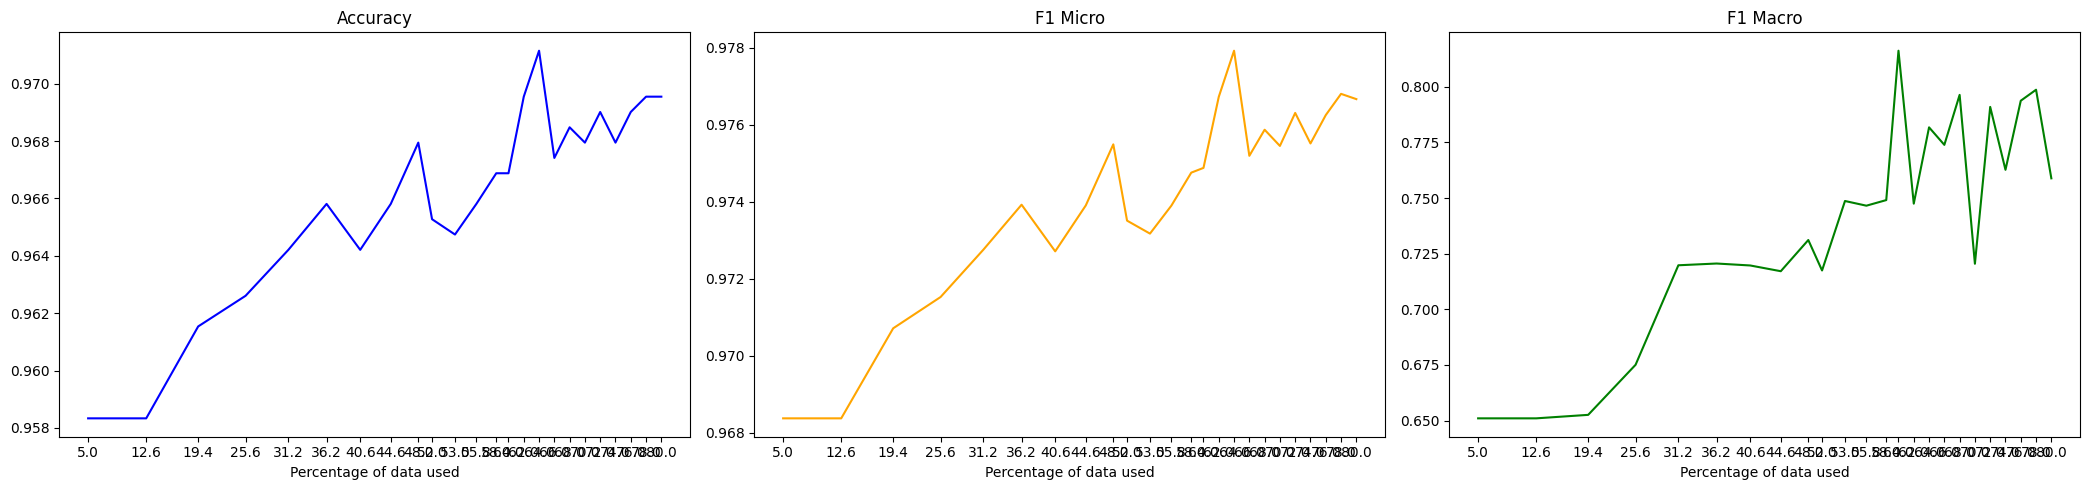

In [21]:
active_learning(seeds[4], 4)